In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from sim import Simulator, SimConfig
from miners.repay_proportional import RepayProportionalShortfallMinerState
from miners.burn import BurnShortfallMinerState
from miners.repay_ratchet import RepayRatchetShortfallMinerState
from miners.base import BaseMinerState
from network import *
from strategy import *
from consts import *

import dataclasses
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
import numpy as np
import jax.numpy as jnp
from jax import grad, jit, vmap, jacfwd
from jax import random

In [4]:
def show_miner_accounting_charts(df):
    plt.figure()
    fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(13.4, 4.8))

    # Balance sheet
    ax1.grid(axis='y', color='#EEE')
    ax1.plot(df['day'], df['net_equity'], label="Net equity")
    ax1.plot(df['day'], df['balance'], label="Balance")
    ax1.plot(df['day'], df['available'], '--', label="Available")
    ax1.plot(df['day'], -df['lease'], label="Lease")
    ax1.plot(df['day'], df['pledge_locked'], '--', label="Pledge locked")
    ax1.set_title("Miner equity")
    ax1.set_xlabel("Day")
    ax1.set_ylabel("FIL")
    ax1.legend()

    # PnL
    ax2.grid(axis='y', color='#EEE')
    ax2.plot(df['day'], df['reward_earned'], label="Rewards")
    ax2.plot(df['day'], -df['fee_burned'], label="Shortfall fee")
    ax2.plot(df['day'], -df['lease_fee_accrued'], label="Lease fee")
    ax2.set_title("Miner cash flow")
    ax2.set_xlabel("Day")
    ax2.legend()

    plt.show()

def compare_configurations(cfgs, title):
    statss = {label: pd.DataFrame(Simulator(cfg).run_all(epochs, stats_interval)) for (label, cfg) in cfgs.items()}

    plt.grid(axis='y', color='#EEE')
    for label, df in statss.items():
        plt.plot(df['day'], df['net_equity'], label=label)

    plt.plot()
    plt.title("Miner equity - " + title)
    plt.xlabel("Day")
    plt.ylabel("FIL")
    plt.legend()
    plt.show()

## Repay the shortfall

In [5]:
days = 3 * YEAR + 1
stats_interval = DAY

In [7]:
# miner_factory = RepayRatchetShortfallMinerState.factory(
#     balance=0,
#     max_repayment_term=3 * YEAR,
#     max_fee_reward_fraction=0.25,
#     reward_projection_decay=REWARD_DECAY + BASELINE_GROWTH
# )

def run_sim(x):
    initial_pledge_projection_period_days = x[0]
    supply_lock_target = x[1]

    network = dataclasses.replace(MAINNET_APR_2023,
        token_lease_fee=0.20,
        reward_decay=REWARD_DECAY, # or try REWARD_DECAY + BASELINE_GROWTH
        initial_pledge_projection_period_days=initial_pledge_projection_period_days,
        supply_lock_target=supply_lock_target
    )

    miner_factory = BaseMinerState.factory(balance=0)
    cfg = SimConfig(
        network=network,
        strategy=StrategyConfig.pledge_limited(1000.0, 3 * YEAR, True),
        miner_factory=miner_factory,
    )
    stats = Simulator(cfg).run_all(days, stats_interval)
    return stats

def jax_wrapper(x):
    stats = run_sim(x)
    
    # JAX doesn't like DataFrames, so we extract the output quantity that we're interested in directly
    # from the dictionary
    net_equity = jnp.array([x['balance'] - x['lease'] for x in stats])
    return net_equity

jacobian = jacfwd(jax_wrapper)

In [11]:
x_in = jnp.array([20.0, 0.3])
stats_df = pd.DataFrame(data=run_sim(x_in))
jc = jacobian(x_in)

In [12]:
jc

DeviceArray([[ 0.0000000e+00,  0.0000000e+00],
             [-2.8782550e-03, -5.4721522e+00],
             [-5.7571768e-03, -1.0945571e+01],
             ...,
             [-3.2297487e+00, -6.1404175e+03],
             [-3.2317841e+00, -6.1442871e+03],
             [-3.2338188e+00, -6.1481558e+03]], dtype=float32)

<Figure size 640x480 with 0 Axes>

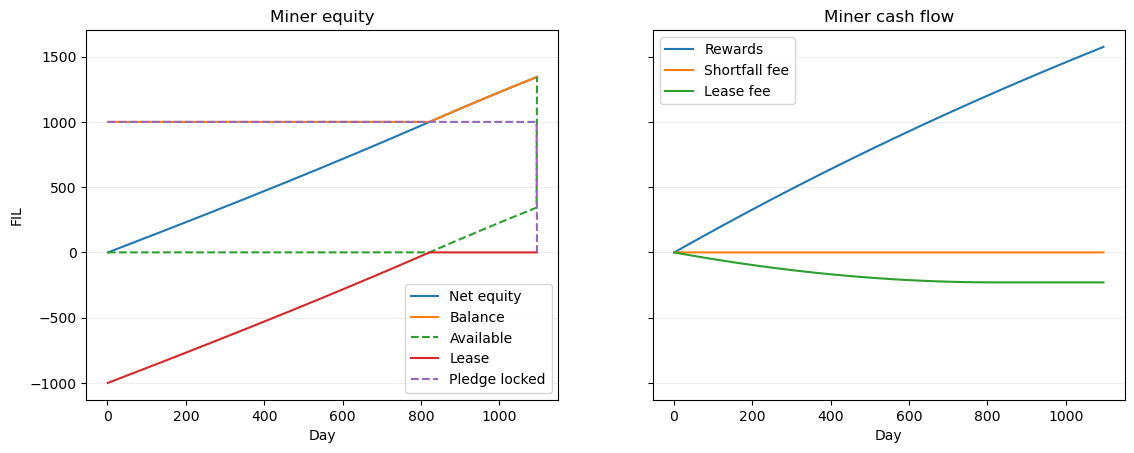

In [13]:
show_miner_accounting_charts(stats_df)

In [ ]:
# Configurations limited by token availability.
compare_configurations({
    'no shortfall': SimConfig(
        network=network,
        strategy=StrategyConfig.pledge_limited(1000.0, 3 * YEAR, False),
        miner_factory=repay_miner_factory,
    ),
    'shortfall': SimConfig(
        network=network,
        strategy=StrategyConfig.pledge_limited(1000.0, 3 * YEAR, True),
        miner_factory=repay_miner_factory,
    )
}, 'repay, limited by tokens')

In [ ]:
compare_configurations({
    'no shortfall': SimConfig(
        network=network,
        strategy=StrategyConfig.power_limited(100*TIBIBYTE, 3*YEAR, False),
        miner_factory=repay_miner_factory,
    ),
    'shortfall': SimConfig(
        network=network,
        strategy=StrategyConfig.power_limited(100*TIBIBYTE, 3*YEAR, True),
        miner_factory=repay_miner_factory,
    )
}, 'repay, limited by power')

## Burn the shortfall

In [ ]:
burn_miner_factory = BurnShortfallMinerState.factory(balance=0)
cfg = SimConfig(
    network=network,
    strategy=StrategyConfig.pledge_limited(1000.0, 3 * YEAR, True),
    miner_factory=burn_miner_factory,
)
stats = Simulator(cfg).run_all(epochs, stats_interval)
burn_shortfall_df = pd.DataFrame(data=stats)
burn_shortfall_df


In [ ]:
show_miner_accounting_charts(burn_shortfall_df)

In [ ]:
# Configurations limited by token availability.
compare_configurations({
    'no shortfall': SimConfig(
        network=network,
        strategy=StrategyConfig.pledge_limited(1000.0, 3 * YEAR, False),
        miner_factory=burn_miner_factory,
    ),
    'shortfall': SimConfig(
        network=network,
        strategy=StrategyConfig.pledge_limited(1000.0, 3 * YEAR, True),
        miner_factory=burn_miner_factory,
    )
}, 'burn-only, limited by tokens')


In [ ]:
compare_configurations({
    'no shortfall': SimConfig(
        network=network,
        strategy=StrategyConfig.power_limited(100 * TIBIBYTE, 3 * YEAR, False),
        miner_factory=burn_miner_factory,
    ),
    'shortfall': SimConfig(
        network=network,
        strategy=StrategyConfig.power_limited(100 * TIBIBYTE, 3 * YEAR, True),
        miner_factory=burn_miner_factory,
    )
}, 'burn-only, limited by power')
